In [3]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
import nltk
import gensim
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
import requests

In [4]:
# Function to scrape text from a website
def scrape_text_from_website(url):
    # Use the requests library to fetch the HTML content of the webpage
    import requests
    from bs4 import BeautifulSoup
    
    response = requests.get(url)
    
    if response.status_code == 200:
        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')
        
        
        # Extract text from the webpage
        text = ' '.join([p.get_text() for p in soup.find_all('p')])
        return text
    else:
        print(f"Failed to fetch content from {url}")
        return None

In [5]:
df = pd.read_csv('dataset.csv')
df

,text,label
0,FLASH SALE | LIMITED TIME ONLY Shop Now,1
1,Pillowcases & Shams,0
2,Write a review,0
3,"To start your return, simply click on the foll...",0
4,newsletter signup (privacy policy),0
...,...,...
2349,Bra Panty Set,0
2350,DressesFootwearHatsHoodies & SweatshirtsJersey...,0
2351,Only 4 left in stock,1
2352,Trending Players,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2354 non-null   object
 1   label   2354 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.9+ KB


In [7]:
df['label'].value_counts()

label
0    1178
1    1176
Name: count, dtype: int64

In [8]:
df.describe()

,label
count,2354.000000
mean,0.499575
std,0.500106
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
df.groupby('label').describe().T

label                          0                                        1
text count                  1178                                     1176
     unique                 1178                                     1176
     top     Pillowcases & Shams  FLASH SALE | LIMITED TIME ONLY Shop Now
     freq                      1                                        1

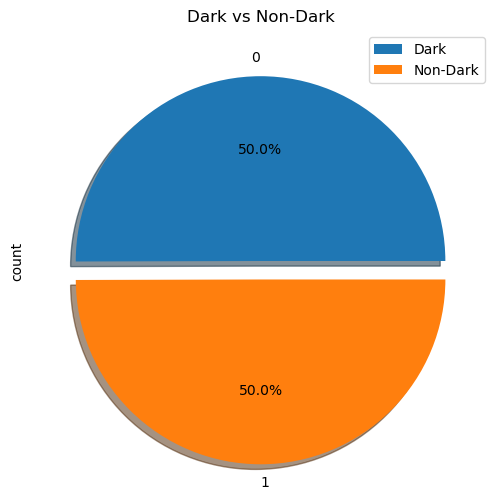

In [10]:
df["label"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Dark vs Non-Dark")
plt.legend(["Dark", "Non-Dark"])
plt.show()

In [11]:
def text_preprocess(txt):
    nopunc = [char for char in txt if char not in string.punctuation]

    nopunc = ''.join(nopunc)
    nopunc = nopunc.lower()
    
    nostop=[word for word in nopunc.split() if word.lower() not in stopwords.words('english') and word.isalpha()]
    
    return nostop

In [12]:
dark = df[df["label"] == 1]["text"]
ndark = df[df["label"] == 0]["text"]
print("dark : ",len(dark))
print("non dark : ",len(ndark))

dark :  1176
non dark :  1178


In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tanis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
dark_words = text_preprocess(dark)

In [15]:
dark_words[0:15]

['flash',
 'sale',
 'limited',
 'time',
 'shop',
 'nowin',
 'left',
 'stockin',
 'stock',
 'leftonly',
 'leftour',
 'best',
 'selling',
 'people',
 'added']

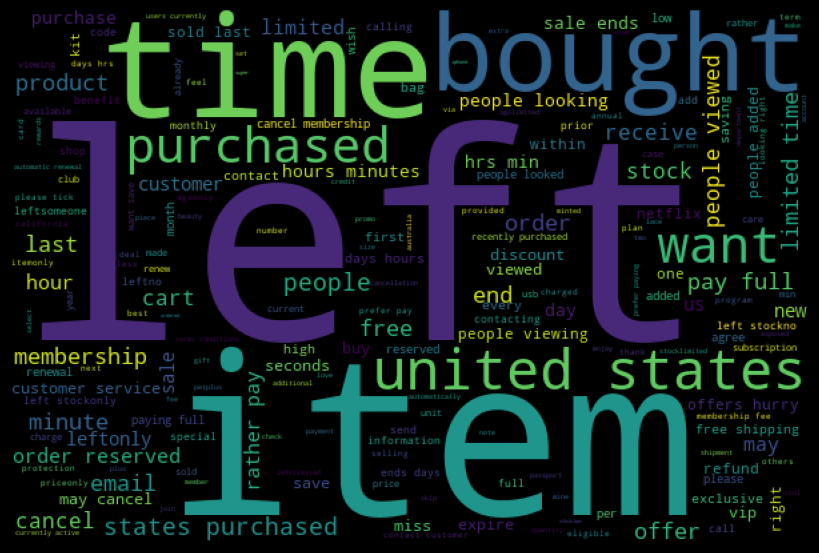

In [16]:
dark_wordcloud = WordCloud(width=600, height=400).generate(' '.join(dark_words))
plt.figure( figsize=(8,6), facecolor='k')
plt.imshow(dark_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [17]:
print("Top 10 dark words:\n")
print(pd.Series(dark_words).value_counts().head(10))

Top 10 dark words:

left         144
people        95
time          82
purchased     78
bought        57
united        52
states        49
like          46
want          45
full          44
Name: count, dtype: int64


In [18]:
ndark_words = text_preprocess(ndark)

In [19]:
ndark_words[:15]

['pillowcases',
 'shamswrite',
 'reviewto',
 'start',
 'simply',
 'click',
 'following',
 'button',
 'add',
 'return',
 'form',
 'receive',
 'email',
 'shipping',
 'instructions']

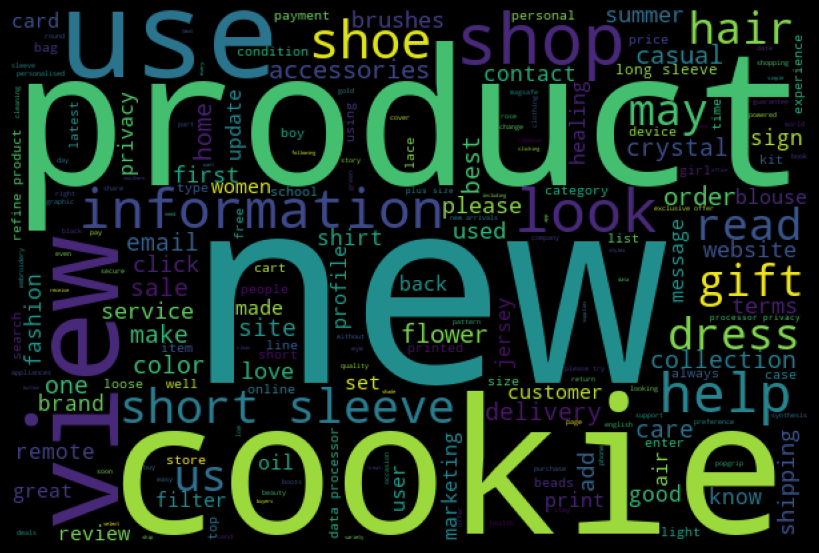

In [20]:
ndark_wordcloud = WordCloud(width=600, height=400).generate(' '.join(ndark_words))
plt.figure( figsize=(8,6), facecolor='k')
plt.imshow(ndark_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [21]:
print("Top 10 Non dark words are :\n")
print(pd.Series(ndark_words).value_counts().head(10))

Top 10 Non dark words are :

new            25
view           24
shop           21
cookies        21
use            20
sleeve         19
product        16
products       14
short          12
information    12
Name: count, dtype: int64


In [22]:
df["text"] = df["text"].apply(text_preprocess)

In [23]:
import gensim

In [24]:
from gensim import models

In [25]:
vector_size_n_w2v = 5

w2v_model = gensim.models.Word2Vec(vector_size=vector_size_n_w2v,
                     window=3,
                     min_count=1,
                     sg=0) # 0=CBOW, 1=Skip-gram

print(w2v_model)

Word2Vec<vocab=0, vector_size=5, alpha=0.025>


In [26]:
w2v_model.build_vocab(df['text'])
print(w2v_model)

Word2Vec<vocab=3440, vector_size=5, alpha=0.025>


In [27]:
w2v_model.train(df['text'], 
                total_examples=w2v_model.corpus_count, 
                epochs=5)

(46919, 53520)

In [28]:
len(w2v_model.wv.index_to_key)

3440

In [29]:
words = set(w2v_model.wv.index_to_key)

def get_word_vectors(words_list, model, max_length):
    vectors = [model.wv[i] for i in words_list if i in words]
    while len(vectors) < max_length:
        vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

MAX_LENGTH = 5000

df['w2v'] = df['text'].apply(lambda x: get_word_vectors(x, w2v_model, MAX_LENGTH))

df['w2v'] = df['w2v'].apply(lambda x: x.flatten()) 

In [30]:
df

,text,label,w2v
0,"[flash, sale, limited, time, shop]",1,"[-0.01674443855881691, 0.1821991503238678, 0.0..."
1,"[pillowcases, shams]",0,"[0.03008975274860859, -0.15937268733978271, -0..."
2,"[write, review]",0,"[-0.186470165848732, -0.020121658220887184, -0..."
3,"[start, return, simply, click, following, butt...",0,"[-0.031976472586393356, -0.16108103096485138, ..."
4,"[newsletter, signup, privacy, policy]",0,"[-0.16632181406021118, -0.03998715803027153, 0..."
...,...,...,...
2349,"[bra, panty, set]",0,"[-0.0852896124124527, -0.03838960453867912, -0..."
2350,"[dressesfootwearhatshoodies, sweatshirtsjersey...",0,"[-0.16891059279441833, 0.006435292307287455, -..."
2351,"[left, stock]",1,"[-0.018674321472644806, 0.00564323365688324, 0..."
2352,"[trending, players]",0,"[-0.12307506054639816, 0.11204679310321808, -0..."


In [31]:
df1 = pd.DataFrame(df['w2v'].tolist(), columns=[f'w2v_{i+1}' for i in range(len(df['w2v'].iloc[0]))])
df1

,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,w2v_10,...,w2v_24991,w2v_24992,w2v_24993,w2v_24994,w2v_24995,w2v_24996,w2v_24997,w2v_24998,w2v_24999,w2v_25000
0,-0.016744,0.182199,0.099809,0.099381,-0.023484,0.182800,-0.177855,0.036908,0.027221,-0.001779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.030090,-0.159373,-0.080030,-0.115083,0.162806,0.114999,-0.047947,0.013222,0.131710,0.135965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.186470,-0.020122,-0.151382,0.054904,-0.053152,0.173113,-0.085549,-0.129616,0.150604,0.075774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.031976,-0.161081,0.012799,0.033164,-0.047021,-0.037918,-0.192584,0.104309,-0.121920,0.099631,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.166322,-0.039987,0.186224,-0.105061,0.020637,0.003535,0.146563,0.084099,0.161813,0.177765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,-0.085290,-0.038390,-0.121956,0.018949,-0.172157,0.166070,-0.163901,0.103227,-0.102872,0.158779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2350,-0.168911,0.006435,-0.020633,0.097266,-0.180731,-0.177850,0.068224,0.005158,-0.140247,-0.000461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2351,-0.018674,0.005643,0.109445,0.173984,-0.204010,-0.156448,0.123803,0.223817,-0.093073,-0.080015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2352,-0.123075,0.112047,-0.133097,-0.109848,0.072806,0.038327,0.135693,-0.127702,-0.091494,-0.052589,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
def preprocess_sentence(sentence):
    tokens = word_tokenize(sentence)

    tokens = [word for word in tokens if word.isalnum()]

    tokens = [word.lower() for word in tokens]

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

def get_word_vectors(words_list, model, max_length):
    vectors = [model.wv[i] for i in words_list if i in model.wv]
    while len(vectors) < max_length:
        vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)

def predict_class_for_sentence(sentence, w2v_model, svm_model, max_length):
    processed_sentence = preprocess_sentence(sentence)

    sentence_w2v = get_word_vectors(processed_sentence, w2v_model, max_length)
    sentence_w2v = sentence_w2v.flatten().reshape(1, -1)

    prediction = svm_model.predict(sentence_w2v)

    return prediction[0]

# XGboost

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X = df1
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb}")

XGBoost Accuracy: 0.8832271762208068


In [35]:
# Save Word2Vec model
w2v_model.save('word2vec_model.bin')

# Save XGBoost model
xgb_model.save_model('xgboost_model.model')

C:\Users\tanis\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:04:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [36]:
import requests
from bs4 import BeautifulSoup

def scrape_cleaned_text_from_website(url):
    try:
        # Send an HTTP request to the URL
        response = requests.get(url)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Parse the HTML content of the webpage using BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')

            # Extract text from all paragraphs (<p> tags)
            paragraphs = soup.find_all('p')

            # Concatenate the text from all paragraphs into a single paragraph
            entire_text = ' '.join([p.get_text() for p in paragraphs])

            # Remove unwanted characters (e.g., \n)
            cleaned_text = ' '.join(entire_text.split())

            return cleaned_text
        else:
            print(f"Failed to fetch content from {url}. Status code: {response.status_code}")
            return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def save_text_to_file(text, filename='scraped_data.txt'):
    try:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(text)
        print(f"Scraped data saved to {filename}")
    except Exception as e:
        print(f"An error occurred while saving to file: {e}")

# Example usage:
website_url = 'https://www.desidime.com/discussions/when-flipkart-shows-you-hurry-only-1-left-is-it-true'
cleaned_text_paragraph = scrape_cleaned_text_from_website(website_url)

if cleaned_text_paragraph:
    print(f"Cleaned text content (paragraph form) scraped from {website_url}:\n")
    print(cleaned_text_paragraph)

    # Save to a text file (overwriting the previous content)
    save_text_to_file(cleaned_text_paragraph)


Cleaned text content (paragraph form) scraped from https://www.desidime.com/discussions/when-flipkart-shows-you-hurry-only-1-left-is-it-true:

Have you purchased the last item and then seen they have another Hurry, Only 1 left! still left in stock? yes , it is true. Thanks for the info, I will skip the purchase then, when its the last item i sometimes get the feeling it must be some returned item lying around, doesn’t want to take a chance. Usually after that, seller changes. You can also check other sellers must have listing at same price Yes it is true i brought last item from shein in large on 18 january and then it said sorry this item is sold out and i took the last one then size small and medium and large we're greyed out saying sorry item sold out i wanted it in small but large was only one left then on 23 january my item came and i looked at the site the items were still sold out on all sizes then looked again on 26 january still all sold out then today i looked back at it and 

In [37]:
cleaned_text_paragraph

"Have you purchased the last item and then seen they have another Hurry, Only 1 left! still left in stock? yes , it is true. Thanks for the info, I will skip the purchase then, when its the last item i sometimes get the feeling it must be some returned item lying around, doesn’t want to take a chance. Usually after that, seller changes. You can also check other sellers must have listing at same price Yes it is true i brought last item from shein in large on 18 january and then it said sorry this item is sold out and i took the last one then size small and medium and large we're greyed out saying sorry item sold out i wanted it in small but large was only one left then on 23 january my item came and i looked at the site the items were still sold out on all sizes then looked again on 26 january still all sold out then today i looked back at it and it says hurry almost sold out only one left and its 31 january and that one must be a returned one because if they were bringing a size back i

In [38]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tanis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [44]:
import requests
from bs4 import BeautifulSoup
import nltk  # Import NLTK
from nltk.tokenize import word_tokenize  # Import word_tokenize

# Download NLTK data files
nltk.download('punkt')

website_url = 'https://en.wikipedia.org/wiki/Main_Page'
cleaned_text_paragraph = scrape_cleaned_text_from_website(website_url)

print("hello1")
if cleaned_text_paragraph:
    print("hello2")
    print(f"Cleaned text content (paragraph form) scraped from {website_url}:\n")
    print(cleaned_text_paragraph)
    
    input_sentence = cleaned_text_paragraph
    # Assuming preprocess_sentence, get_word_vectors, and predict_class_for_sentence are defined
    processed_sentence = preprocess_sentence(input_sentence)
    sentence_w2v = get_word_vectors(processed_sentence, w2v_model, MAX_LENGTH)
    sentence_w2v = sentence_w2v.flatten().reshape(1, -1)

    predicted_class = predict_class_for_sentence(input_sentence, w2v_model, xgb_model, MAX_LENGTH)
    print(f"Predicted class for the input sentence: {predicted_class}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tanis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


hello1
hello2
Cleaned text content (paragraph form) scraped from https://en.wikipedia.org/wiki/Main_Page:

SMS Prinz Adalbert was an armored cruiser built in the early 1900s for the German Kaiserliche Marine, and was named after Prince Adalbert of Prussia, the former commander-in-chief of the Prussian Navy. Her class included a second ship, Friedrich Carl. Prinz Adalbert was built at the Imperial Dockyard in Kiel. Her keel was laid in April 1900 and she was commissioned on 12 January 1904. She served as a gunnery training ship and made several visits to foreign countries. After the outbreak of World War I in July 1914 she served in the Baltic Sea, and after her sister ship was sunk in November 1914, she became the flagship of a cruiser squadron in the Baltic, conducting operations against Russian forces. She was torpedoed twice by British submarines in 1915. On the second occasion she sank quickly with heavy loss of life; from a crew of 675 men, only 3 were rescued. This was the worst 

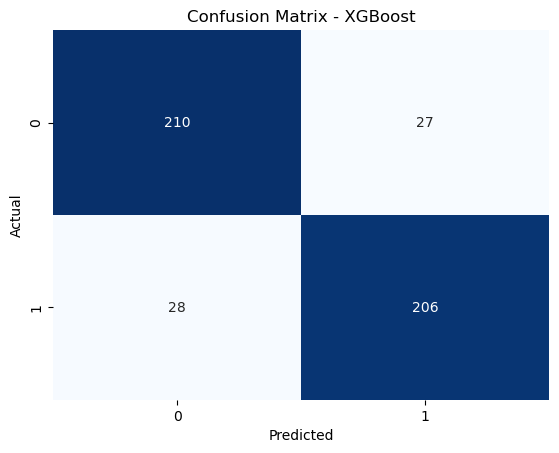

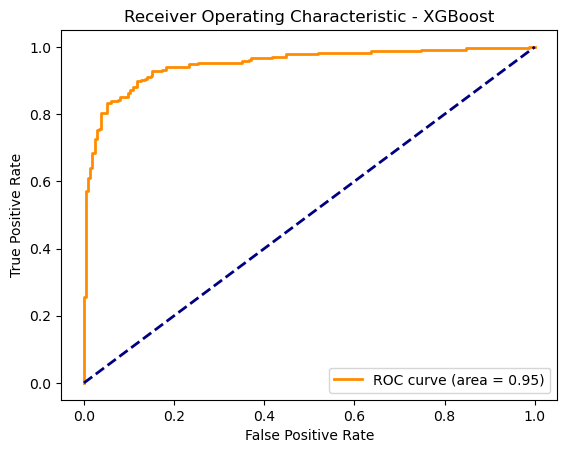

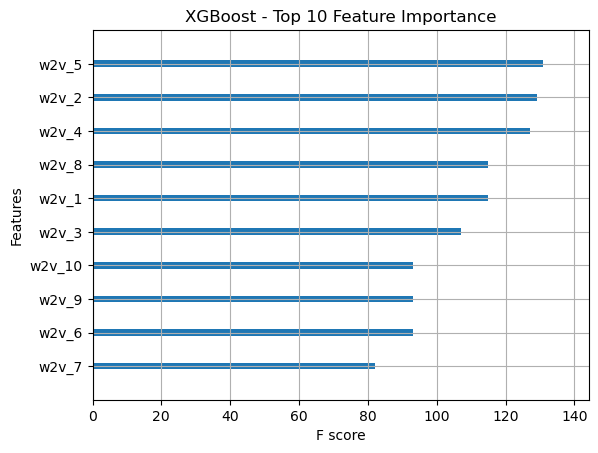

In [41]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_xgb))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc='lower right')
plt.show()

# Feature Importance Plot
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=10, importance_type='weight', show_values=False)
plt.title('XGBoost - Top 10 Feature Importance')
plt.show()